# 📘 AI Project: Realistic Face Generation with a DCGAN

This notebook provides a complete, end-to-end walkthrough for building and training a Deep Convolutional Generative Adversarial Network (DCGAN) to generate realistic human faces. It's designed for students and junior developers, with clear explanations, modular code, and a focus on hands-on learning.

---

## 1. 📌 Project Definition & Goal Setting

### What is Image Generation?

Image generation is a fascinating field in artificial intelligence where we teach a machine to create new, original images from scratch. Instead of recognizing or classifying images, the model learns the underlying patterns, textures, and features of a dataset to produce entirely novel visuals that resemble the data it was trained on.

### What are GANs and Diffusion Models?

They are two popular families of generative models.

- **Generative Adversarial Networks (GANs):**  
  Think of a GAN as a competition between two neural networks:
  - 🎨 **The Generator:** An "art forger" that tries to create realistic images (e.g., faces) from random noise.
  - 🕵️ **The Discriminator:** A "detective" that tries to distinguish between real images (from the dataset) and fake images (from the generator). They train together. The Generator gets better at fooling the Discriminator, and the Discriminator gets better at catching fakes. This adversarial process pushes the Generator to produce increasingly realistic images.
  - We'll be building a **DCGAN**, a specific type of GAN that uses convolutional layers.

- **Diffusion Models (e.g., DDPM):**  
  These models work differently. They take a real image, gradually add noise to it until it becomes pure static, and then train a neural network to reverse this process. To generate a new image, the trained model starts with random noise and carefully "denoises" it step-by-step, sculpting a clean, coherent image.

### What Problem Are We Solving?

Our goal is to train a DCGAN on the CelebA dataset to generate new, plausible, and diverse 64x64 pixel images of human faces. These faces should not be copies of the training data but entirely new creations of the model.

### Why is This Important?

Generative models are transforming industries:

- **Art & Creativity:** Creating AI-generated art and design concepts.
- **Synthetic Data:** Generating realistic but artificial data to train other AI models, especially in privacy-sensitive domains like medicine (e.g., generating synthetic X-rays).
- **Entertainment:** Creating characters, environments, and special effects in games and movies.
- **Fashion & E-commerce:** Visualizing models wearing different outfits.

### What Does "Success" Look Like?

Success means our trained Generator can take a random vector of numbers and produce a sharp, realistic face that a human would find believable. We'll evaluate this by visually inspecting grids of generated images.

---

## 2. 🧾 Data Acquisition & Preparation

We'll use the **CelebA** dataset, which contains over 200,000 celebrity face images. It's perfect for this task due to its large size and focus on a single, coherent object class (faces). `torchvision` makes it incredibly easy to download and use.

> **Note:** The CelebA dataset is quite large (~1.3 GB). The first time you run the cell below, it will take a significant amount of time to download.


In [1]:
import os
import zipfile

# Target directory
data_root = "/kaggle/working/celeba_data"
os.makedirs(data_root, exist_ok=True)

# Download CelebA images from Udacity mirror
celeba_url = "https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/celeba.zip"
zip_path = os.path.join(data_root, "celeba.zip")

# Download if not already present
if not os.path.exists(zip_path):
    !wget -c "$celeba_url" -O "$zip_path"
else:
    print("✅ celeba.zip already downloaded.")

# Extract
extract_folder = os.path.join(data_root, "img_align_celeba")
if not os.path.exists(extract_folder):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(data_root)
    print("✅ CelebA images extracted to:", extract_folder)
else:
    print("✅ CelebA already extracted.")


--2025-08-05 16:03:13--  https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/celeba.zip
Resolving s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)... 52.219.192.80, 16.15.0.163, 52.219.117.40, ...
Connecting to s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)|52.219.192.80|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1443490838 (1.3G) [application/zip]
Saving to: ‘/kaggle/working/celeba_data/celeba.zip’

/kaggle/working/cel 100%[===================>]   1.34G  12.9MB/s    in 79s     

2025-08-05 16:04:33 (17.4 MB/s) - ‘/kaggle/working/celeba_data/celeba.zip’ saved [1443490838/1443490838]

✅ CelebA images extracted to: /kaggle/working/celeba_data/img_align_celeba


## 3. 🧪 Exploratory Data Analysis (EDA)

Let's look at what our data actually looks like. We'll visualize a small batch of images to understand their properties like size, color, and diversity. Since we've already extracted the images, we can load them directly from the folder.



Shape of a batch: torch.Size([64, 3, 64, 64])
Data type: torch.float32
Pixel value range: Min=0.0, Max=1.0

Visualizing a grid of sample images...


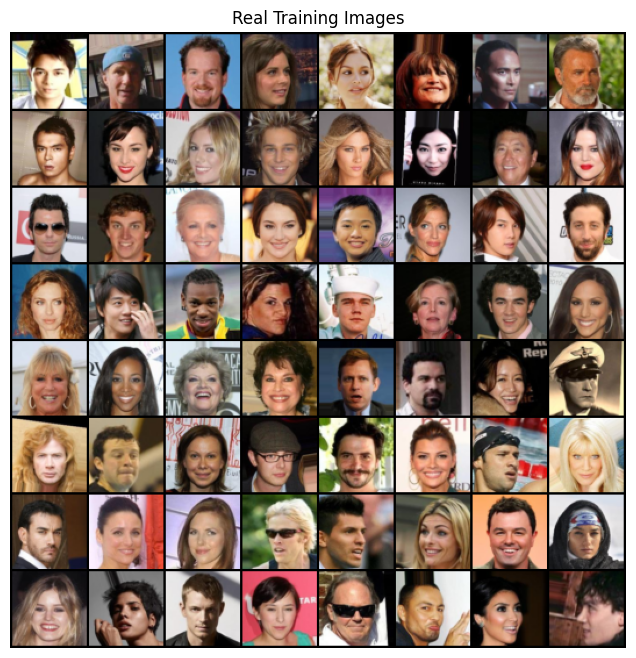

In [2]:
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt

# Set the image folder path
image_dir = "/kaggle/working/celeba_data/img_align_celeba"

# Define transform
transform = transforms.Compose([
    transforms.Resize(64),
    transforms.CenterCrop(64),
    transforms.ToTensor()
])

# Custom Dataset class
class CelebADataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.image_files = [f for f in os.listdir(image_dir) if f.endswith(".jpg")]
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_files[idx])
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image

# Create dataset and dataloader
dataset = CelebADataset(image_dir=image_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True, num_workers=2)

# Sample batch
real_batch = next(iter(dataloader))

# Show batch info
print(f"Shape of a batch: {real_batch.shape}")
print(f"Data type: {real_batch.dtype}")
print(f"Pixel value range: Min={real_batch.min()}, Max={real_batch.max()}")
print("\nVisualizing a grid of sample images...")

# Visualize
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Real Training Images")
image_grid = vutils.make_grid(real_batch[:64], padding=2, normalize=False).numpy()
plt.imshow(np.transpose(image_grid, (1, 2, 0)))
plt.show()


### Observations

- The images are **diverse**, featuring different people, genders, accessories (like glasses), and backgrounds. This diversity is beneficial as it encourages the generator to learn a wide range of facial features[1][2].
- The images are **well-aligned**: faces are centered, which simplifies the training process because the generator does not need to learn face detection or alignment[1].
- The raw pixel values (after `ToTensor()`) are in the range **[0.0, 1.0]**. We will further normalize these values for model training.


# 4. 🛠️ Data Preprocessing & Pipeline Creation

For a DCGAN, we need a consistent image size and a specific normalization scheme. The generator's final activation function is tanh, which outputs values in the range [-1, 1]. Therefore, we must normalize our real images to this same range.  
We'll set up our final PyTorch DataLoader, which will handle batching, shuffling, and applying these transformations on the fly.

In [3]:
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os
import torchvision.transforms as transforms

# ----------------------------
# ✅ Configuration & Hyperparameters
# ----------------------------

workers = 2             # Number of subprocesses used for data loading (speed boost)
batch_size = 128        # Number of images per training batch
image_size = 64         # Input image size (height/width). GANs use powers of 2 (e.g., 64, 128)
nc = 3                  # Number of channels in the training images (3 for RGB)
nz = 100                # Size of the input noise vector z (latent space input to generator)
ngf = 64                # Base number of feature maps in the generator (scales output channels)
ndf = 64                # Base number of feature maps in the discriminator (scales down channels)
num_epochs = 10         # Number of full passes over the dataset (more = better results)
lr = 0.0002             # Learning rate for both generator and discriminator optimizers
beta1 = 0.5             # Beta1 value for Adam optimizer (helps with stable GAN training)
torch.manual_seed(999)  # Set random seed for reproducibility (ensures same results on rerun)

# ----------------------------
# ✅ Data Pipeline Setup
# ----------------------------

# Path to extracted CelebA images
extract_folder = "/kaggle/working/celeba_data/img_align_celeba"

# Define the image transformation pipeline
transform = transforms.Compose([
    transforms.Resize(image_size),                    # Resize to 64x64
    transforms.CenterCrop(image_size),                # Center crop (for square output)
    transforms.ToTensor(),                            # Convert PIL image to PyTorch tensor
    transforms.Normalize((0.5, 0.5, 0.5),              # Normalize RGB channels to [-1, 1]
                         (0.5, 0.5, 0.5))              # Required when using Tanh in generator
])

# Define a custom dataset class to handle flat folder (no subdirectories)
class CelebADataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        # Get all JPG files in the directory
        self.image_files = [f for f in os.listdir(image_dir) if f.endswith(".jpg")]
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_files[idx])
        image = Image.open(img_path).convert("RGB")  # Ensure 3-channel RGB
        if self.transform:
            image = self.transform(image)
        return image

# Create dataset instance
dataset = CelebADataset(image_dir=extract_folder, transform=transform)

# Create DataLoader to feed batches to the model
dataloader = DataLoader(dataset,
                        batch_size=batch_size,
                        shuffle=True,     # Shuffle for better training
                        num_workers=workers)

# ----------------------------
# ✅ Confirmation
# ----------------------------
print("✅ DataLoader created successfully.")
print(f"Total images in dataset: {len(dataset)}")
print(f"Each batch will contain: {batch_size} images")


✅ DataLoader created successfully.
Total images in dataset: 202599
Each batch will contain: 128 images


# 4. 🛠️ Data Preprocessing & Pipeline Creation  (contd...)

### **Why These Steps?**  

1. **`Resize & CenterCrop`**  
   - Ensures all images are a uniform **64×64** size, which is a manageable and computationally efficient dimension for training.  
   - Maintains consistency in input dimensions, which is required for stable GAN training.  

2. **`ToTensor`**  
   - Converts images from **PIL format** to **PyTorch tensors** (required for deep learning operations).  
   - Scales pixel values from **[0, 255]** to **[0, 1]**, making optimization easier.  

3. **`Normalize`**  
   - Shifts the **[0, 1]** range to **[-1, 1]** using the formula:  
     \[
     \text{output} = \frac{\text{input} - 0.5}{0.5}
     \]  
   - This is **crucial** because the generator's final activation (`tanh`) outputs values in **[-1, 1]**, so real images must match this range for proper adversarial training.  

4. **`DataLoader`**  
   - **Batching**: Groups data into batches for efficient GPU processing.  
   - **Shuffling**: Randomizes the order each epoch to prevent the model from memorizing sequences.  
   - **Parallel Loading**: Uses multiple CPU workers (`num_workers`) to prefetch data, preventing training bottlenecks.  

# 5. 🧠 Model Selection & Architecture  
We will implement the **DCGAN** architecture, following the guidelines from the [original paper](https://arxiv.org/abs/1511.06434).  

---

## **The Generator (G)**  
The generator takes a **latent vector `z`** (a 100-dimensional noise vector) as input and upsamples it through transposed convolutions to produce a **3×64×64** fake image.  

### **Key Components**  
1. **`ConvTranspose2d`**  
   - The "opposite" of a regular convolution—**upsamples** the input by increasing spatial dimensions.  
   - Used to progressively expand the noise vector into an image.  

2. **`BatchNorm2d`**  
   - **Stabilizes training** by normalizing layer activations.  
   - Helps avoid issues like vanishing/exploding gradients.  

3. **`ReLU`** (Hidden Layers)  
   - Introduces **non-linearity** to help the model learn complex patterns.  
   - Applied in all hidden layers except the final one.  

4. **`Tanh`** (Final Activation)  
   - Squashes the output to **[-1, 1]**, matching the normalized input range of real images.  

---

## **The Discriminator (D)**  
The discriminator takes a **3×64×64 image** (real or fake) and downsamples it through convolutions, outputting a **single probability** (0 = fake, 1 = real).  

### **Key Components**  
1. **`Conv2d`**  
   - Standard **convolutional layers** for downsampling and feature extraction.  
   - Reduces spatial dimensions while increasing channel depth.  

2. **`LeakyReLU`** (α=0.2)  
   - Unlike ReLU, it allows a **small negative slope** for inactive neurons.  
   - Prevents "dead neurons" and improves gradient flow in GANs.  

3. **`Sigmoid`** (Final Activation)  
   - Outputs a **probability score** between **[0, 1]**, indicating real/fake confidence.  

---

### **Why This Architecture Works**  
- **Transposed Convolutions (Generator)** gradually build high-resolution images from noise.  
- **BatchNorm (Both G & D)** stabilizes training by preventing extreme weight updates.  
- **LeakyReLU (Discriminator)** avoids sparse gradients, improving adversarial learning.  
- **Tanh/Sigmoid** ensure outputs match expected ranges for stable training.  

This setup follows DCGAN best practices for generating high-quality images. 🚀  

In [4]:
import torch
import torch.nn as nn

# ✅ Define device for training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ✅ Define model hyperparameters
nz = 100     # Latent vector (z) size
ngf = 64     # Size of feature maps in generator
ndf = 64     # Size of feature maps in discriminator
nc = 3       # Number of channels in the training images (3 for RGB)

# ✅ Custom weights initialization (DCGAN paper guideline)
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

# ============================
# 🧠 Generator Architecture
# ============================

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # Input: Z latent vector (nz) → (ngf*8) x 4 x 4
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),

            # (ngf*8) x 4 x 4 → (ngf*4) x 8 x 8
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),

            # (ngf*4) x 8 x 8 → (ngf*2) x 16 x 16
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),

            # (ngf*2) x 16 x 16 → (ngf) x 32 x 32
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),

            # (ngf) x 32 x 32 → (nc) x 64 x 64
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)

# Create Generator and initialize weights
netG = Generator().to(device)
netG.apply(weights_init)
print("--- Generator Architecture ---")
print(netG)

# ===============================
# 🧠 Discriminator Architecture
# ===============================

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # Input: (nc) x 64 x 64 → (ndf) x 32 x 32
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            # (ndf) x 32 x 32 → (ndf*2) x 16 x 16
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),

            # (ndf*2) x 16 x 16 → (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),

            # (ndf*4) x 8 x 8 → (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),

            # (ndf*8) x 4 x 4 → 1 output
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()  # outputs probability of real vs fake
        )

    def forward(self, input):
        return self.main(input)

# Create Discriminator and initialize weights
netD = Discriminator().to(device)
netD.apply(weights_init)
print("\n--- Discriminator Architecture ---")
print(netD)


--- Generator Architecture ---
Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias

# 6. 🎯 Training & Validation  
This is where the magic happens! We'll define our loss functions, optimizers, and implement the adversarial training loop.

---

## **Loss Functions & Optimizers**  

### **Binary Cross Entropy Loss (BCELoss)**  
- Used for this binary classification task (real vs. fake images)  
- The GAN loss functions are:  

**Discriminator Loss**:  
\[
\mathcal{L}_D = -\mathbb{E}_{x \sim p_{data}}[\log D(x)] - \mathbb{E}_{z \sim p_z}[\log(1 - D(G(z)))]
\]  
- Maximizes ability to:  
  - Correctly classify real images (D(x) → 1)  
  - Correctly reject fake images (D(G(z)) → 0)  

**Generator Loss**:  
\[
\mathcal{L}_G = -\mathbb{E}_{z \sim p_z}[\log D(G(z))]
\]  
- Maximizes probability that fake images are classified as real (D(G(z)) → 1)  

### **Optimizers**  
- **Adam optimizer** for both networks (as recommended in DCGAN paper)  
- Typical learning rate: 0.0002 (helps maintain training stability)  

---

## **The Training Loop**  

For each epoch, we:  

### **1️⃣ Train the Discriminator**  
1. **Real Images**:  
   - Forward pass real batch (x) → calculate loss (D(x) should be 1)  
2. **Fake Images**:  
   - Generate fake images (G(z)) → calculate loss (D(G(z)) should be 0)  
3. **Update**:  
   - Sum both losses → backpropagate → update Discriminator weights  

### **2️⃣ Train the Generator**  
1. Generate new fake images (G(z))  
2. Calculate loss (now D(G(z)) should be 1)  
3. Backpropagate → update Generator weights  

---

## **Monitoring Progress**  
- **Fixed Noise Visualization**:  
  - Periodically generate images from a fixed noise vector (`fixed_noise`)  
  - Allows tracking how generated images improve over time  
- **Loss Tracking**:  
  - Plot both generator and discriminator losses to check training stability  

> **Pro Tip**: If D_loss → 0 too quickly, the generator may be failing to learn (mode collapse). Adjust learning rates or add noise if this occurs!

---

### **Why This Works**  
- The **adversarial dynamic** pushes both networks to improve:  
  - Discriminator becomes better at detecting fakes  
  - Generator becomes better at fooling the discriminator  
- **Adam optimizer** helps navigate the complex loss landscape  
- **Fixed noise samples** provide consistent evaluation during training  

This training process is the core of how GANs learn to generate realistic images! 🪄  

In [5]:
import torch.optim as optim

# Loss function
criterion = nn.BCELoss()

# Fixed noise to monitor generator's progress
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Real and fake labels
real_label = 1.
fake_label = 0.

# Optimizers for both Generator and Discriminator
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

# Tracking progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("🚀 Starting Training Loop...")
for epoch in range(num_epochs):
    for i, data in enumerate(dataloader, 0):
        ############################
        # (1) Update D: maximize log(D(x)) + log(1 - D(G(z)))
        ############################
        netD.zero_grad()

        # 🟢 Real data
        real_cpu = data.to(device)  # <- FIXED LINE
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        output = netD(real_cpu).view(-1)
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        # 🔴 Fake data
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        fake = netG(noise)
        label.fill_(fake_label)
        output = netD(fake.detach()).view(-1)
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()

        # Update D
        errD = errD_real + errD_fake
        optimizerD.step()

        ############################
        # (2) Update G: maximize log(D(G(z)))
        ############################
        netG.zero_grad()
        label.fill_(real_label)  # trick D into thinking fake is real
        output = netD(fake).view(-1)
        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()

        ############################
        # 🔍 Logging & Image Sampling
        ############################
        if i % 100 == 0:
            print(f"[{epoch+1}/{num_epochs}][{i}/{len(dataloader)}] "
                  f"Loss_D: {errD.item():.4f} Loss_G: {errG.item():.4f} "
                  f"D(x): {D_x:.4f} D(G(z)): {D_G_z1:.4f} / {D_G_z2:.4f}")

        # Save losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Save generated samples
        if (iters % 500 == 0) or ((epoch == num_epochs - 1) and (i == len(dataloader) - 1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

print("✅ Training Finished!")


🚀 Starting Training Loop...
[1/10][0/1583] Loss_D: 1.7883 Loss_G: 6.5228 D(x): 0.6758 D(G(z)): 0.6682 / 0.0027
[1/10][100/1583] Loss_D: 0.7212 Loss_G: 14.4659 D(x): 0.9270 D(G(z)): 0.3466 / 0.0000
[1/10][200/1583] Loss_D: 0.4547 Loss_G: 4.3640 D(x): 0.8290 D(G(z)): 0.1319 / 0.0215
[1/10][300/1583] Loss_D: 2.6716 Loss_G: 3.3478 D(x): 0.1928 D(G(z)): 0.0009 / 0.0787
[1/10][400/1583] Loss_D: 0.5399 Loss_G: 5.4235 D(x): 0.8750 D(G(z)): 0.2565 / 0.0115
[1/10][500/1583] Loss_D: 0.4638 Loss_G: 3.4928 D(x): 0.8058 D(G(z)): 0.1353 / 0.0516
[1/10][600/1583] Loss_D: 0.2884 Loss_G: 4.5237 D(x): 0.8688 D(G(z)): 0.0901 / 0.0310
[1/10][700/1583] Loss_D: 0.9653 Loss_G: 5.6167 D(x): 0.8855 D(G(z)): 0.4948 / 0.0070
[1/10][800/1583] Loss_D: 0.3280 Loss_G: 4.1882 D(x): 0.8762 D(G(z)): 0.1441 / 0.0235
[1/10][900/1583] Loss_D: 2.5502 Loss_G: 11.3197 D(x): 0.9909 D(G(z)): 0.8426 / 0.0001
[1/10][1000/1583] Loss_D: 0.5191 Loss_G: 6.5001 D(x): 0.9025 D(G(z)): 0.2862 / 0.0030
[1/10][1100/1583] Loss_D: 0.3855 Los

## Visualizing Training Progress

Now, let's plot the Generator and Discriminator losses to see how they competed during training. Then we'll visualize the images generated from our fixed_noise vector over time.

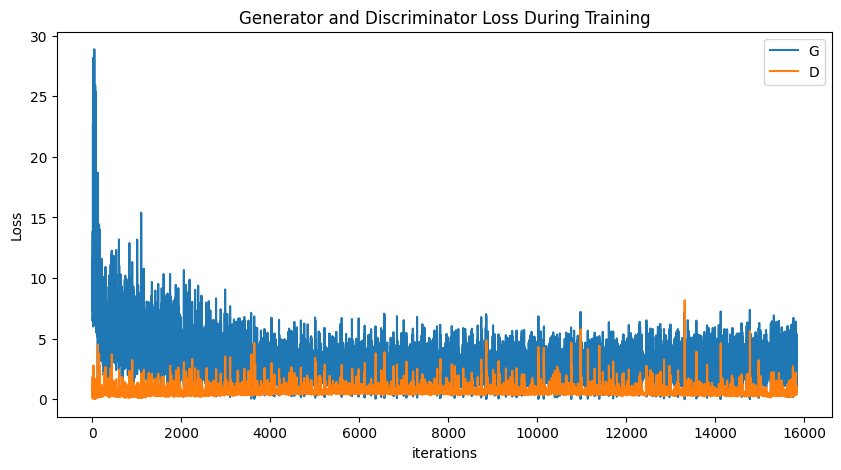

In [ ]:
# Plot the loss curves
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

## 7. 📈 Evaluation & Hyperparameter Tuning

### Qualitative Evaluation
The primary way to evaluate a GAN like this is qualitatively: do the images look good?

- **Realism & Sharpness**: Are the faces sharp, or are they blurry, distorted messes?
- **Diversity**: Is the generator producing a wide variety of faces, or has it suffered from mode collapse (i.e., it only produces a few very similar-looking faces)?
- **Artifacts**: Are there checkerboard patterns or other strange visual artifacts in the images?

Looking at the final grid of fake images, we can judge our success. Early in training, they will look like noise. After several epochs, distinct facial features should emerge.

### Quantitative Evaluation (Optional)
For more rigorous evaluation, researchers use metrics like:

- **Fréchet Inception Distance (FID)**: Measures the similarity between the distribution of generated images and the distribution of real images using features from a pre-trained InceptionV3 network. A lower FID score is better.
- **Inception Score (IS)**: Measures both the quality (realism) and diversity of generated images. A higher IS is better.

These are more complex to implement and are not necessary for a starter project but are good to know about.

### Hyperparameter Tuning
You can dramatically change the results by tuning the hyperparameters defined in Section 4. Here are some ideas for experimentation:

- **num_epochs**: This is the most important one. GANs need time. Training for 25, 50, or even 100 epochs will yield significantly better results than the 10 we used for this demo.
- **lr (Learning Rate)**: If the losses oscillate wildly, the learning rate might be too high. If they barely change, it might be too low. 0.0002 is a good starting point.
- **nz (Latent Vector Size)**: A larger nz (e.g., 128, 256) might give the generator more capacity to create diverse images, but can also be harder to train.
- **ngf & ndf**: Increasing the number of feature maps (ngf, ndf) makes the models "wider" and more powerful, but also more computationally expensive.

## 8. 🏁 Final Model Training & Testing
After experimenting, you would retrain the model from scratch using your best hyperparameters for the full number of epochs. Once training is complete, the most important step is to save your trained model weights.

Models saved to /kaggle/working/dcgan_generator.pth and /kaggle/working/dcgan_discriminator.pth

✅ Generator model loaded successfully and set to evaluation mode.
Generating a new grid of faces from the loaded model...


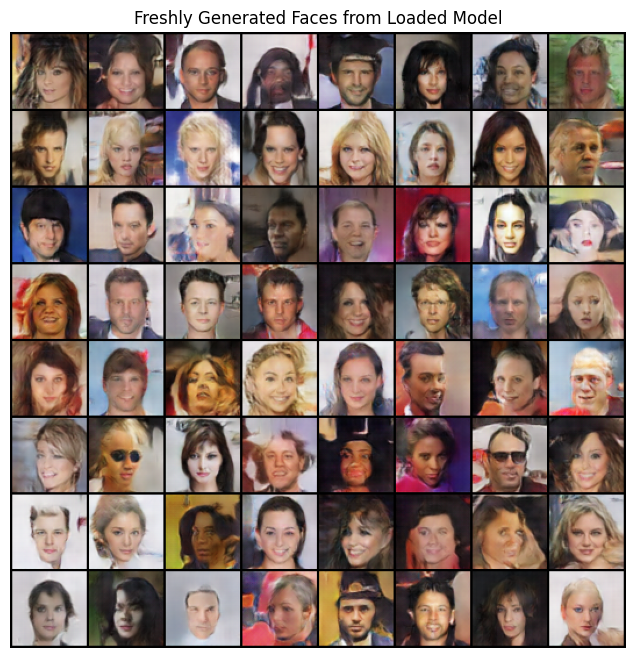

In [7]:
# --- Save the Final Trained Models ---
output_dir = "/kaggle/working/"
generator_path = os.path.join(output_dir, 'dcgan_generator.pth')
discriminator_path = os.path.join(output_dir, 'dcgan_discriminator.pth')

torch.save(netG.state_dict(), generator_path)
torch.save(netD.state_dict(), discriminator_path)

print(f"Models saved to {generator_path} and {discriminator_path}")

# --- How to Load and Use the Saved Model ---

# 1. Re-create the model architecture
loaded_generator = Generator().to(device)

# 2. Load the saved state dictionary
loaded_generator.load_state_dict(torch.load(generator_path))

# 3. Set the model to evaluation mode
loaded_generator.eval()

print("\n✅ Generator model loaded successfully and set to evaluation mode.")


# --- Generate a New Batch of Images ---
print("Generating a new grid of faces from the loaded model...")

# Create new random noise
new_noise = torch.randn(64, nz, 1, 1, device=device)

# Generate images with the loaded model
with torch.no_grad():
    generated_images = loaded_generator(new_noise).detach().cpu()

# Visualize the new images
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Freshly Generated Faces from Loaded Model")
plt.imshow(np.transpose(vutils.make_grid(generated_images, padding=2, normalize=True), (1,2,0)))
plt.show()

## 9. 🚀 Deployment & Monitoring (Next Steps)
While we won't implement deployment here, it's the natural next step. A trained generator is a portable model that can be used in other applications.

### Lightweight Deployment Options
- **Streamlit UI**: Create a simple web app using Streamlit. You could add a button that says "Generate New Face," which would run your loaded generator and display the image. This is excellent for creating interactive demos.
- **Flask/FastAPI API**: Wrap your generator in a web API using Flask or FastAPI. An endpoint could accept a request and return a generated image file. This allows other programs and services to get images from your model.

### Monitoring
- **Generation Quality**: If this model were used in a real application, you'd want to monitor the quality of its output over time. Are the images still looking good?
- **Re-training**: Generative models are an active area of research. You might need to re-train your model if a better architecture (like StyleGAN or a Diffusion Model) becomes available or if your source dataset is updated or improved.

This notebook provides a solid foundation. You can now easily swap the dataset (e.g., to FashionMNIST), tune the model, or try to implement a different architecture entirely. Happy generating! 🤖✨